<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Natural language processing
## Based on rules bot with DNN + Spacy

### 1 - Install dependencies

In [2]:
# Intall packages
!pip install -U spacy==3.1 --quiet
!pip install -U spacy-stanza==1.0.0 --quiet

     |████████████████████████████████| 6.4 MB 5.2 MB/s 
     |████████████████████████████████| 451 kB 64.0 MB/s 
     |████████████████████████████████| 10.1 MB 52.9 MB/s 
     |████████████████████████████████| 653 kB 35.1 MB/s 
     |████████████████████████████████| 42 kB 1.2 MB/s 
     |████████████████████████████████| 342 kB 5.1 MB/s 


In [3]:
# Import libraries
import re
import unicodedata
import string
from typing import Dict, Any
import csv
import json
import random
import numpy as np
import stanza
import spacy_stanza
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf 
from tensorflow.keras import Sequential 
from tensorflow.keras.layers import Dense, Dropout

In [4]:
# Download english dictionary
stanza.download("en")
nlp = spacy_stanza.load_pipeline("en")

2022-03-20 22:31:57 INFO: Downloading default packages for language: en (English)...


2022-03-20 22:33:19 INFO: Finished downloading models and saved to /root/stanza_resources.
2022-03-20 22:33:19 INFO: Loading these models for language: en (English):
| Processor | Package   |
-------------------------
| tokenize  | combined  |
| pos       | combined  |
| lemma     | combined  |
| depparse  | combined  |
| sentiment | sstplus   |
| ner       | ontonotes |

2022-03-20 22:33:19 INFO: Use device: cpu
2022-03-20 22:33:19 INFO: Loading: tokenize
2022-03-20 22:33:19 INFO: Loading: pos
2022-03-20 22:33:19 INFO: Loading: lemma
2022-03-20 22:33:19 INFO: Loading: depparse
2022-03-20 22:33:20 INFO: Loading: sentiment
2022-03-20 22:33:21 INFO: Loading: ner
2022-03-20 22:33:22 INFO: Done loading processors!


In [5]:
# Preprocess data
def preprocess_clean_text(text: str) -> str:
    # Pass text to lowercase
    text = text.lower()    
    # Eliminate accents in the text
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    # Eliminate special characters
    pattern = r'[^a-zA-z0-9.,!?/:;\"\'\s]' 
    text = re.sub(pattern, '', text)
    pattern = r'[^a-zA-z.,!?/:;\"\'\s]' 
    # Get rid of numbers
    text = re.sub(pattern, '', text)
    # Elimninate punctuations
    text = ''.join([c for c in text if c not in string.punctuation])
    return text

# Read dataset
<!-- [WikiQA](https://www.microsoft.com/en-us/download/confirmation.aspx?id=52419) -->

<!-- [Question Answer Dataset](https://www.cs.cmu.edu/~ark/QA-data/data/Question_Answer_Dataset_v1.2.tar.gz) -->

<!-- [Stanford Question Answering Dataset](https://rajpurkar.github.io/SQuAD-explorer/) -->

Using Kaggle dataset for intent classication: [Intent Classification](https://www.kaggle.com/datasets?search=Intent+Classification)

In [6]:
# def file_text_to_dict(file_name: str) -> Dict[str, Any]:
#     dataset_dict = {}
#     with open(file_name, encoding='mac_roman') as tsv:
#         for i, line in enumerate(csv.reader(tsv, delimiter="\t")):
#             if i == 0:
#                 continue
#             elif line[0] not in dataset_dict:
#                 dataset_dict[line[0]] = {}
#                 dataset_dict[line[0]]["patterns"] = [line[1]]
#                 dataset_dict[line[0]]["responses"] = [line[2]]
#             else:
#                 if not line[1] in dataset_dict[line[0]]["patterns"]:
#                     dataset_dict[line[0]]["patterns"].append(line[1])
#                 if not line[2] in dataset_dict[line[0]]["responses"]:
#                     dataset_dict[line[0]]["responses"].append(line[2])
#     print(dataset_dict)

#file_text_to_dict("question_answer_pairs.txt")

In [8]:
# Read dataset
f = open('Intent.json')
dataset = json.load(f)

In [9]:
# Create list to store words and classes
words = []
classes = []
doc_X = []
doc_y = []

for intent in dataset["intents"]:
    for pattern in intent["text"]:
        # Transform into tokens
        tokens = nlp(preprocess_clean_text(pattern.lower()))
        # lemmatization
        for token in tokens:            
            words.append(token.lemma_)
        
        doc_X.append(pattern)
        doc_y.append(intent["intent"])
    
    # Add intents to classes list
    if intent["intent"] not in classes:
        classes.append(intent["intent"])

# Elimante duplicates
words = sorted(set(words))
classes = sorted(set(classes))

In [10]:
# Obtained information
print("words:", words)
print("classes:", classes)
print("doc_X:", doc_X)
print("doc_y:", doc_y)

words: ['I', 'a', 'about', 'adam', 'adio', 'any', 'anyone', 'aware', 'bay', 'be', 'bella', 'bored', 'by', 'bye', 'call', 'camera', 'can', 'cheer', 'clever', 'communicate', 'comprendo', 'conscious', 'could', 'do', 'door', 'enough', 'for', 'friend', 'fuck', 'genious', 'get', 'girl', 'give', 'good', 'goodbye', 'gossip', 'great', 'have', 'hear', 'hello', 'help', 'helpful', 'hi', 'hola', 'hope', 'how', 'hya', 'identify', 'in', 'intelligent', 'it', 'joke', 'know', 'late', 'laugh', 'make', 'mean', 'more', 'my', 'name', 'need', 'not', 'off', 'ok', 'open', 'please', 'pod', 'prove', 'quiet', 'real', 'say', 'see', 'self', 'selfaware', 'shhh', 'shit', 'shut', 'some', 'speak', 'stop', 'surely', 'talk', 'tell', 'thank', 'thanks', 'thats', 'the', 'there', 'think', 'this', 'time', 'to', 'twat', 'understand', 'up', 'user', 'very', 'want', 'wasnt', 'well', 'what', 'who', 'why', 'will', 'with', 'you']
classes: ['Clever', 'CourtesyGoodBye', 'CourtesyGreeting', 'CourtesyGreetingResponse', 'CurrentHumanQuer

In [11]:
# Vocabulary length
print("Vocabulary:", len(words))

# Number of tags
print("Tags:", len(classes))

Vocabulary: 106
Tags: 22


In [12]:
# Transform to OneHotEncoding
training = []
out_empty = [0] * len(classes)

for idx, doc in enumerate(doc_X):
    # Transform question (input) into tokens and lemmatize
    text = []
    tokens = nlp(preprocess_clean_text(doc.lower()))
    for token in tokens:
        text.append(token.lemma_)

    # Transform tokens into bag of words
    bow = []
    for word in words:
        bow.append(1) if word in text else bow.append(0)
    
    # Create output array
    output_row = list(out_empty)
    output_row[classes.index(doc_y[idx])] = 1

    training.append([bow, output_row])

# Shuffle data
random.shuffle(training)
training = np.array(training, dtype=object)
# Divide training set
train_X = np.array(list(training[:, 0]))
train_y = np.array(list(training[:, 1]))

# Training

In [13]:
# Get input and output shape
input_shape = (train_X.shape[1],)
output_shape = train_y.shape[1]
print("input:", input_shape, "output:", output_shape)

input: (106,) output: 22


In [14]:
# Create model
model = Sequential()
model.add(Dense(128, input_shape=input_shape, activation="leaky_relu"))
model.add(Dropout(0.5))
model.add(Dense(64, activation="leaky_relu"))
model.add(Dropout(0.5))
model.add(Dense(output_shape, activation = "softmax"))

model.compile(loss='categorical_crossentropy',
              optimizer="Adam",
              metrics=["accuracy"])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               13696     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 22)                1430      
                                                                 
Total params: 23,382
Trainable params: 23,382
Non-trainable params: 0
_________________________________________________________________
None


In [15]:
# Train
hist = model.fit(x=train_X, y=train_y, epochs=200)

Epoch 1/200
5/5 [==============================] - 2s 10ms/step - loss: 3.1122 - accuracy: 0.0559
Epoch 2/200
5/5 [==============================] - 0s 11ms/step - loss: 3.0748 - accuracy: 0.0769
Epoch 3/200
5/5 [==============================] - 0s 9ms/step - loss: 3.0282 - accuracy: 0.0979
Epoch 4/200
5/5 [==============================] - 0s 7ms/step - loss: 2.9827 - accuracy: 0.1329
Epoch 5/200
5/5 [==============================] - 0s 7ms/step - loss: 2.9542 - accuracy: 0.1608
Epoch 6/200
5/5 [==============================] - 0s 5ms/step - loss: 2.8870 - accuracy: 0.1399
Epoch 7/200
5/5 [==============================] - 0s 8ms/step - loss: 2.8838 - accuracy: 0.1678
Epoch 8/200
5/5 [==============================] - 0s 9ms/step - loss: 2.8271 - accuracy: 0.2797
Epoch 9/200
5/5 [==============================] - 0s 8ms/step - loss: 2.7702 - accuracy: 0.2727
Epoch 10/200
5/5 [==============================] - 0s 7ms/step - loss: 2.7340 - accuracy: 0.3147
Epoch 11/200
5/5 [=========

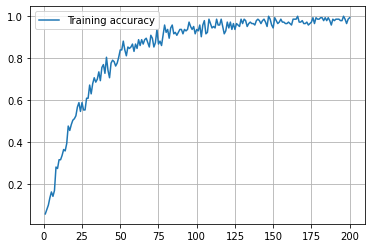

In [16]:

# Plot training accuracy
epoch_count = range(1, len(hist.history['accuracy']) + 1)
sns.lineplot(x=epoch_count,  y=hist.history['accuracy'], label='Training accuracy')
plt.grid()
plt.show()


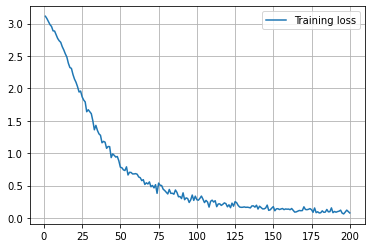

In [17]:
sns.lineplot(x=epoch_count,  y=hist.history['loss'], label='Training loss')
plt.grid()
plt.show()

In [18]:
import pickle
pickle.dump(words, open('words.pkl','wb'))
pickle.dump(classes, open('classes.pkl','wb'))
model.save('chatbot_model.h5')

In [22]:
from datetime import datetime

class Environment():
  def __init__(self):
      self.human_name = "NULL"
  def getTime(self):
      now = datetime.now()
      return now.strftime("%H:%M:%S")
  def updateHuman(self, name):
      self.human_name = name
      return self.human_name
  def getCurrentHuman(self):
      return self.human_name
  

In [23]:

environment = Environment()

def text_to_tokens(text): 
    lemma_tokens = []
    tokens = nlp(preprocess_clean_text(text.lower()))
    for token in tokens:
        lemma_tokens.append(token.lemma_)
    return lemma_tokens

def bag_of_words(text, vocab): 
    tokens = text_to_tokens(text)
    bow = [0] * len(vocab)
    for w in tokens: 
        for idx, word in enumerate(vocab):
            if word == w: 
                bow[idx] = 1
    return np.array(bow)

def pred_class(text, vocab, labels): 
    bow = bag_of_words(text, vocab)
    words_recognized = sum(bow)

    return_list = []
    if words_recognized > 0:
        result = model.predict(np.array([bow]))[0]
        thresh = 0.2
        y_pred = [[idx, res] for idx, res in enumerate(result) if res > thresh]
        y_pred.sort(key=lambda x: x[1], reverse=True)
    
        for r in y_pred:
            return_list.append(labels[r[0]])

    return return_list

def get_response(intents_list, intents_json, message):
    tag = intents_list[0]
    list_of_intents = intents_json["intents"]
    for i in list_of_intents: 
        result = ""
        if i["intent"] == tag:
            random_response = random.choice(i["responses"])
            if not "<" in random_response:
                result += "BOT: " + random_response
            if i["extension"]["function"]:
                args = []
                if i["intent"] == "GreetingResponse":
                    args.append(message.split()[-1])
                value = getattr(environment, i["extension"]["function"].split(".")[-1])(*args)
                result += "\nBOT: " + random.choice(i["extension"]["responses"])
                if value:
                    result = re.sub(r"\%\%[A-Za-z]+\%\%", value, result)
            break
    return result

In [ ]:
while True:
    message = input("")
    intents = pred_class(message, words, classes)
    if len(intents) > 0:
        result = get_response(intents, dataset, message)
        print(result)
    else:
        print("Sorry, I could not understand")

Hi!
BOT: Hi human, please tell me your GeniSys user
I am Gonzalo

BOT: OK hi Gonzalo, what can I do for you?
What is your name
BOT: You may call me Geni
What time is it
BOT: One sec
BOT: It is around 22:39:13
Thank you Geni
BOT: Happy to help!
